<a href="https://colab.research.google.com/github/antidude900/pytorch_learning/blob/main/02_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

In [3]:
len(X),len(y)

(1000, 1000)

In [4]:
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


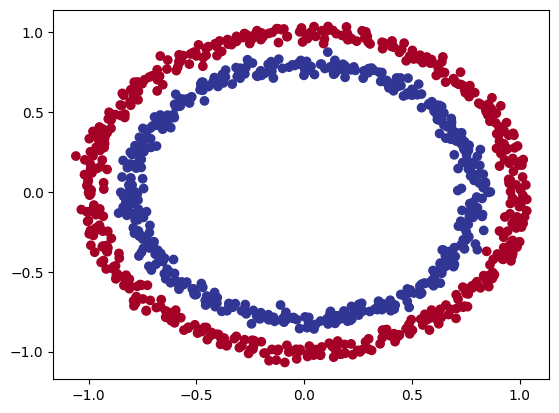

In [5]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [6]:
X.shape,y.shape

((1000, 2), (1000,))

In [7]:
import torch

In [8]:
X =  torch.from_numpy(X).type(torch.float)
y =  torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [10]:
from torch import nn

device  = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
device

'cuda'

In [12]:

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Linear(2,10),
        nn.ReLU(),
        nn.Linear(10,10),
        nn.ReLU(),
        nn.Linear(10,1),

    ).to(device)

  def forward(self,x):
    return self.layer(x)

model_0 = CircleModelV0().to(device)
model_0
next(model_0.parameters()).device

device(type='cuda', index=0)

In [13]:
model_0.state_dict()

OrderedDict([('layer.0.weight',
              tensor([[ 0.4241, -0.2017],
                      [-0.2775, -0.5952],
                      [ 0.6986,  0.2558],
                      [ 0.2643, -0.2433],
                      [-0.0766,  0.0372],
                      [-0.6526,  0.1859],
                      [-0.5546,  0.3156],
                      [-0.0318,  0.2162],
                      [-0.0178,  0.3197],
                      [-0.3490, -0.1563]], device='cuda:0')),
             ('layer.0.bias',
              tensor([-0.0158,  0.6012,  0.4709,  0.4847,  0.0331, -0.3852,  0.2019,  0.0384,
                       0.3702, -0.0727], device='cuda:0')),
             ('layer.2.weight',
              tensor([[ 0.1364,  0.1009,  0.1191,  0.0150, -0.2220, -0.1544,  0.0996,  0.0239,
                       -0.2240,  0.2473],
                      [ 0.2797, -0.3040, -0.0824,  0.2899,  0.0912, -0.2371, -0.0848, -0.0862,
                        0.3002,  0.0435],
                      [ 0.0209, -0.065

In [14]:
with torch.inference_mode():
  untrained_pred = model_0(X_test.to(device))

untrained_pred[:5],y_test[:5]

(tensor([[0.2754],
         [0.2538],
         [0.2769],
         [0.2658],
         [0.2821]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.]))

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.01)

In [16]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [17]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.2754],
        [0.2538],
        [0.2769],
        [0.2658],
        [0.2821]], device='cuda:0')

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5684],
        [0.5631],
        [0.5688],
        [0.5661],
        [0.5701]], device='cuda:0')

In [19]:
y_pred =  torch.round(y_pred_probs)

In [20]:
epochs = 20000
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs+1):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch % 1000 == 0:

    model_0.eval()
    with torch.inference_mode():
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))

      test_loss = loss_fn(test_logits,y_test)
      test_acc = accuracy_fn(y_test,test_pred)

    print(f"Epoch:{epoch} | Loss:{loss:.5f}, Acc:{acc:.2f} | Test loss:{test_loss:.5f}, Test Acc:{test_acc:.2f}")


Epoch:0 | Loss:0.70254, Acc:50.00 | Test loss:0.70300, Test Acc:50.00
Epoch:1000 | Loss:0.68889, Acc:62.00 | Test loss:0.68927, Test Acc:61.00
Epoch:2000 | Loss:0.68658, Acc:65.12 | Test loss:0.68756, Test Acc:58.00
Epoch:3000 | Loss:0.68344, Acc:66.50 | Test loss:0.68526, Test Acc:60.50
Epoch:4000 | Loss:0.67907, Acc:65.62 | Test loss:0.68200, Test Acc:61.50
Epoch:5000 | Loss:0.67278, Acc:66.25 | Test loss:0.67717, Test Acc:64.00
Epoch:6000 | Loss:0.66355, Acc:68.00 | Test loss:0.66990, Test Acc:65.50
Epoch:7000 | Loss:0.64952, Acc:70.25 | Test loss:0.65842, Test Acc:68.50
Epoch:8000 | Loss:0.62531, Acc:81.50 | Test loss:0.63858, Test Acc:76.50
Epoch:9000 | Loss:0.58313, Acc:87.88 | Test loss:0.60310, Test Acc:87.00
Epoch:10000 | Loss:0.51295, Acc:94.12 | Test loss:0.54084, Test Acc:91.00
Epoch:11000 | Loss:0.40623, Acc:98.12 | Test loss:0.44706, Test Acc:94.50
Epoch:12000 | Loss:0.28296, Acc:99.62 | Test loss:0.32814, Test Acc:98.00
Epoch:13000 | Loss:0.18433, Acc:99.88 | Test loss:0

In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper function.py already exists!")
else:
  print("Downloading helper_functions.py")
  request  =  requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions,plot_decision_boundary

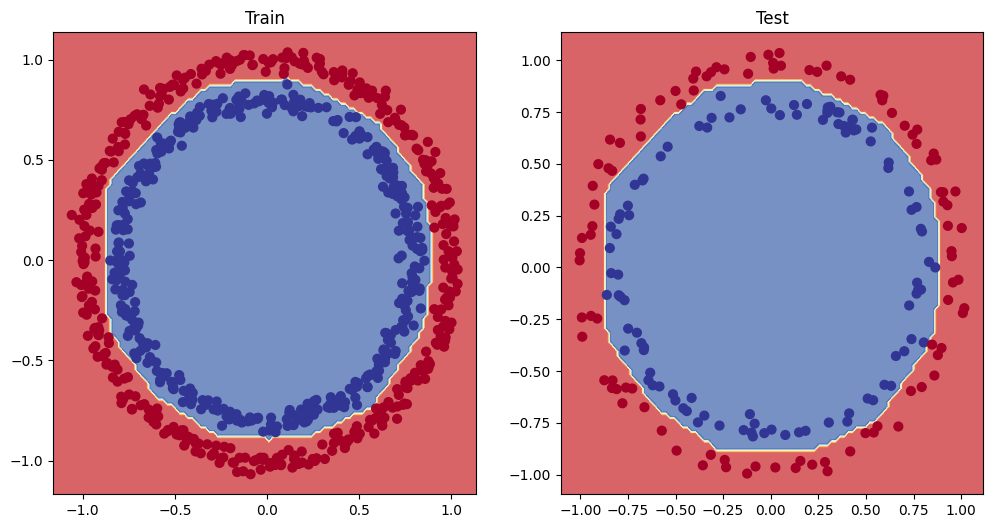

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

# Multi class classification


In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [34]:
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


In [35]:
x_blob,y_blob = make_blobs(n_samples=1000,n_features=NUM_FEATURES,centers=NUM_CLASSES,cluster_std=1.5,random_state=RANDOM_SEED)
x_blob,y_blob = torch.from_numpy(x_blob).type(torch.float),torch.from_numpy(y_blob).type(torch.LongTensor)

x_blob_train,x_blob_test,y_blob_train,y_blob_test =  train_test_split(x_blob,y_blob,test_size=0.2,random_state = RANDOM_SEED)


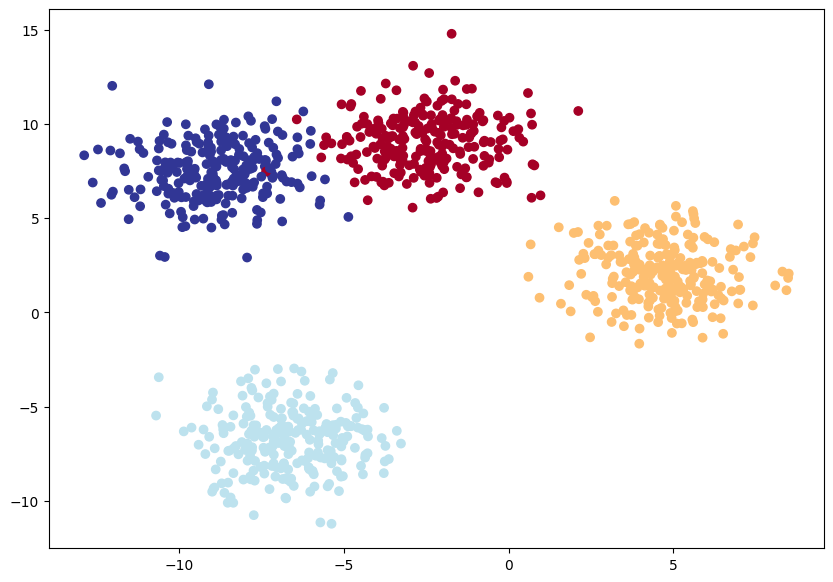

In [36]:
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0],x_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [37]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [38]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [39]:
model_blob = BlobModel(input_features=2,hidden_units=8,output_features=4).to(device)
model_blob

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [40]:
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_blob.parameters(),lr=0.01)

In [41]:
epochs = 20000
x_blob_train = x_blob_train.to(device)
y_blob_train = y_blob_train.to(device)
x_blob_test = x_blob_test.to(device)
y_blob_test = y_blob_test.to(device)

for epoch in range(epochs+1):
  model_blob.train()

  y_logits = model_blob(x_blob_train).squeeze()
  y_pred = torch.argmax(torch.softmax(y_logits,dim=1),dim=1)

  loss = loss_fn(y_logits,y_blob_train)
  acc = accuracy_fn(y_blob_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  if epoch % 1000 == 0:

    model_blob.eval()
    with torch.inference_mode():
      test_logits = model_blob(x_blob_test).squeeze()
      test_pred = torch.argmax(torch.softmax(test_logits,dim=1),dim=1)

      test_loss = loss_fn(test_logits,y_blob_test)
      test_acc = accuracy_fn(y_blob_test,test_pred)

    print(f"Epoch:{epoch} | Loss:{loss:.5f}, Acc:{acc:.2f} | Test loss:{test_loss:.5f}, Test Acc:{test_acc:.2f}")


Epoch:0 | Loss:1.68556, Acc:24.12 | Test loss:1.56063, Test Acc:28.50
Epoch:1000 | Loss:0.01360, Acc:99.38 | Test loss:0.00324, Test Acc:100.00
Epoch:2000 | Loss:0.01122, Acc:99.50 | Test loss:0.00160, Test Acc:100.00
Epoch:3000 | Loss:0.01075, Acc:99.50 | Test loss:0.00155, Test Acc:100.00
Epoch:4000 | Loss:0.01033, Acc:99.75 | Test loss:0.00153, Test Acc:100.00
Epoch:5000 | Loss:0.01020, Acc:99.75 | Test loss:0.00141, Test Acc:100.00
Epoch:6000 | Loss:0.01010, Acc:99.75 | Test loss:0.00133, Test Acc:100.00
Epoch:7000 | Loss:0.01002, Acc:99.50 | Test loss:0.00123, Test Acc:100.00
Epoch:8000 | Loss:0.01038, Acc:99.50 | Test loss:0.00125, Test Acc:100.00
Epoch:9000 | Loss:0.00965, Acc:99.50 | Test loss:0.00095, Test Acc:100.00
Epoch:10000 | Loss:0.01073, Acc:99.62 | Test loss:0.00125, Test Acc:100.00
Epoch:11000 | Loss:0.01188, Acc:99.50 | Test loss:0.00107, Test Acc:100.00
Epoch:12000 | Loss:0.00952, Acc:99.50 | Test loss:0.00083, Test Acc:100.00
Epoch:13000 | Loss:0.00956, Acc:99.50 |

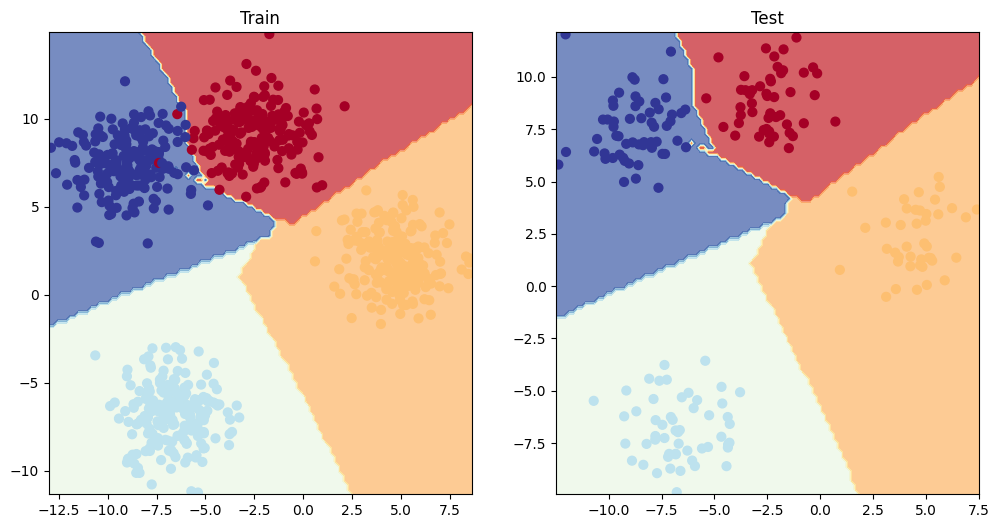

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_blob,x_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_blob,x_blob_test,y_blob_test)